**CUSTOM DATASET CLEANING**

In [ ]:
import os
import shutil

# Corrected paths
images_path = "/content/drive/MyDrive/custom_bottle/COMPUTER VISION"  # images folder
labels_path = "/content/drive/MyDrive/annoted_bottle"                 # labels folder

# Output (clean dataset)
output_images = "/content/drive/MyDrive/clean_bottle/images"
output_labels = "/content/drive/MyDrive/clean_bottle/labels"

# Create clean folders
os.makedirs(output_images, exist_ok=True)
os.makedirs(output_labels, exist_ok=True)

# Collect files
valid_img_exts = [".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG"]
images = [f for f in os.listdir(images_path) if os.path.splitext(f)[1] in valid_img_exts]
labels = [f for f in os.listdir(labels_path) if f.lower().endswith(".txt")]

# Strip extensions + force lowercase for comparison
image_basenames = set([os.path.splitext(f)[0].lower() for f in images])
label_basenames = set([os.path.splitext(f)[0].lower() for f in labels])

# Intersection → only valid pairs
valid_files = image_basenames & label_basenames
print(f"✅ Found {len(valid_files)} valid pairs out of {len(images)} images and {len(labels)} labels")

# Copy valid pairs
for base in valid_files:
    # Find actual image file (any extension)
    img_file = None
    for f in images:
        if os.path.splitext(f)[0].lower() == base:
            img_file = f
            break

    # Find label file
    lbl_file = None
    for f in labels:
        if os.path.splitext(f)[0].lower() == base:
            lbl_file = f
            break

    # Copy both
    if img_file and lbl_file:
        shutil.copy(os.path.join(images_path, img_file), os.path.join(output_images, img_file))
        shutil.copy(os.path.join(labels_path, lbl_file), os.path.join(output_labels, lbl_file))

print("🎉 Clean dataset created at:")
print("   Images →", output_images)
print("   Labels →", output_labels)


✅ Found 92 valid pairs out of 299 images and 93 labels
🎉 Clean dataset created at:
   Images → /content/drive/MyDrive/clean_bottle/images
   Labels → /content/drive/MyDrive/clean_bottle/labels


**TRAIN-TEST SPLIT**

In [ ]:
import os, shutil, random

# Paths
images_dir = "/content/drive/MyDrive/clean_bottle/images"
labels_dir = "/content/drive/MyDrive/clean_bottle/labels"
base_out = "/content/drive/MyDrive/yolo_bottle_dataset"

# Train/val split ratio
split_ratio = 0.8

# Output folders
for split in ["train", "val"]:
    os.makedirs(os.path.join(base_out, "images", split), exist_ok=True)
    os.makedirs(os.path.join(base_out, "labels", split), exist_ok=True)

# Get all image files
images = [f for f in os.listdir(images_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
random.shuffle(images)

# Split
split_idx = int(len(images) * split_ratio)
train_imgs, val_imgs = images[:split_idx], images[split_idx:]

def move_pairs(img_list, split):
    for img in img_list:
        base = os.path.splitext(img)[0]
        label = base + ".txt"
        # Copy image
        shutil.copy(os.path.join(images_dir, img), os.path.join(base_out, "images", split, img))
        # Copy label
        shutil.copy(os.path.join(labels_dir, label), os.path.join(base_out, "labels", split, label))

move_pairs(train_imgs, "train")
move_pairs(val_imgs, "val")

print(f"✅ Split completed! {len(train_imgs)} train and {len(val_imgs)} val images.")


✅ Split completed! 73 train and 19 val images.


In [ ]:
yaml_content = """
train: /content/drive/MyDrive/yolo_bottle_dataset/images/train
val: /content/drive/MyDrive/yolo_bottle_dataset/images/val

nc: 1
names: ['plastic_bottle']
"""

# Save the yaml file
with open("/content/drive/MyDrive/yolo_bottle_dataset/data.yaml", "w") as f:
    f.write(yaml_content)

print("✅ data.yaml created at /content/drive/MyDrive/yolo_bottle_dataset/data.yaml")


✅ data.yaml created at /content/drive/MyDrive/yolo_bottle_dataset/data.yaml


**DOWNLOADING YOLO11 LATEST VERSION**

In [ ]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.1 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

# Pick a pretrained YOLO11 model; for speed/smaller dataset start with a small one
model = YOLO("yolo11n.pt")  # n = Nano; other options: s (small), m (medium), etc.


ModuleNotFoundError: No module named 'ultralytics'

**TRAINING**

In [ ]:
results = model.train(
    data="/content/drive/MyDrive/yolo_bottle_dataset/data.yaml",
    epochs=15,        # keep small, so training fits in 10-15 min
    imgsz=416,        # smaller image size → faster training
    batch=8,          # small batch size (safe for Colab GPU)
    workers=2,
    project="/content/drive/MyDrive/yolo11_bottle_training",
    name="quick_run"
)


Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/yolo_bottle_dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=quick_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspe

In [ ]:
metrics = model.val()
print(metrics)


Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.3 ms, read: 37.7±33.5 MB/s, size: 148.4 KB)
val: Scanning /content/drive/MyDrive/yolo_bottle_dataset/labels/val.cache... 19 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 19/19 4.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 1.2it/s 2.4s
                   all         19         25    0.00439       0.96       0.63      0.399
Speed: 0.9ms preprocess, 94.8ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to /content/drive/MyDrive/yolo11_bottle_training/quick_run2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79a1d7761eb0>
curve

In [ ]:
ls /content/drive/MyDrive/yolo11_bottle_training/*/weights


/content/drive/MyDrive/yolo11_bottle_training/quick_run/weights:
best.pt  last.pt

/content/drive/MyDrive/yolo11_bottle_training/yolo11_plastic_bottle/weights:


**IMPLEMENTATION**

Saving photo_2.jpg to photo_2 (4).jpg

image 1/1 /content/photo_2 (4).jpg: 640x512 1 bottle, 201.5ms
Speed: 3.6ms preprocess, 201.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)
Results saved to /content/runs/detect/predict7


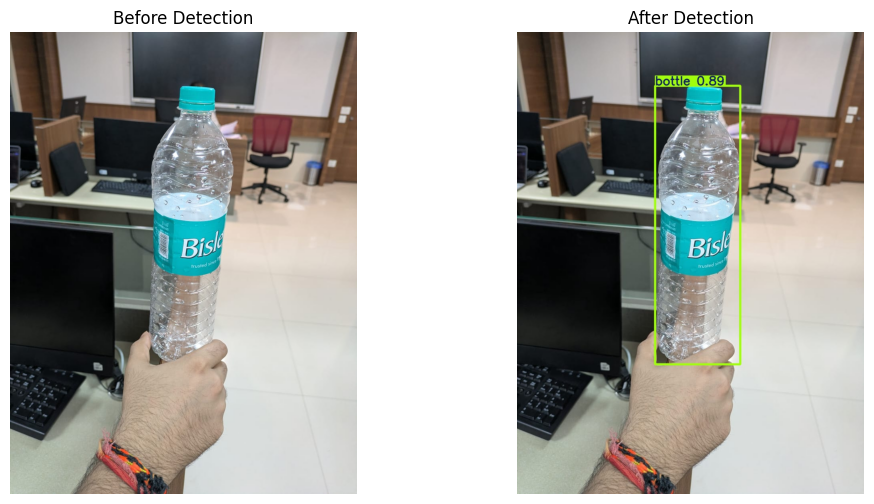

✅ Result saved at: /content/runs/detect/predict7/photo_2 (4).jpg


In [ ]:
from ultralytics import YOLO
from google.colab import files
import matplotlib.pyplot as plt
import cv2

# --- Load YOLO11 from Drive (renamed custom copy) ---
model = YOLO("/content/drive/MyDrive/yolo11custom.pt")

# --- Upload an image ---
uploaded = files.upload()

for filename in uploaded.keys():
    img_path = filename

    # Show original image
    orig = cv2.imread(img_path)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(orig)
    plt.title("Before Detection")
    plt.axis("off")

    # Run detection but ONLY for class 'bottle'
    results = model.predict(
        source=img_path,
        save=True,
        conf=0.25,
        classes=[39]   # COCO class index for 'bottle'
    )

    # Show filtered detection result
    output_path = results[0].save_dir + "/" + filename
    det = cv2.imread(output_path)
    det = cv2.cvtColor(det, cv2.COLOR_BGR2RGB)

    plt.subplot(1,2,2)
    plt.imshow(det)
    plt.title("After Detection")
    plt.axis("off")

    plt.show()

    print("✅ Result saved at:", output_path)


**WEBSITE**

In [ ]:
import gradio as gr
from ultralytics import YOLO

# --- Load your YOLO11 model (from Drive) ---
model = YOLO("/content/drive/MyDrive/yolo11custom.pt")

# --- Prediction function ---
def detect_bottle(image):
    results = model.predict(
        source=image,
        conf=0.25,
        classes=[39]   # only "bottle"
    )
    return results[0].plot()   # annotated numpy array

# --- Title + Description ---
title = "🍼 Plastic Bottle Detection with YOLO11"
description = """
<h3 style="text-align: center; color: #4CAF50;">
Real-time Bottle Detection using YOLO11
</h3>
<p style="text-align: center;">
Upload an image or try an example below. <br>
The model will detect and highlight <b>bottles</b> in the picture.
</p>
"""

# --- Example Images (add more if you like) ---
examples = [
    ["https://ultralytics.com/images/bus.jpg"],
    ["https://ultralytics.com/images/zidane.jpg"]
]

# --- Build Interface with Columns ---
with gr.Blocks(theme=gr.themes.Soft(primary_hue="green", secondary_hue="blue")) as demo:
    gr.HTML(f"<div style='text-align:center; font-size:24px; font-weight:bold;'>{title}</div>")
    gr.HTML(description)

    with gr.Row():
        with gr.Column():
            inp = gr.Image(type="numpy", label="Upload Your Image", elem_id="input-img")
            run_btn = gr.Button("🔍 Detect Bottles", variant="primary")
        with gr.Column():
            out = gr.Image(type="numpy", label="Detection Result", elem_id="output-img")

    gr.Examples(examples=examples, inputs=inp, outputs=out, fn=detect_bottle, cache_examples=True)

    run_btn.click(fn=detect_bottle, inputs=inp, outputs=out)

# --- Launch the App ---
demo.launch(debug=True, share=True)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Caching examples at: '/content/.gradio/cached_examples/9'

0: 640x480 (no detections), 426.8ms
Speed: 58.9ms preprocess, 426.8ms inference, 29.9ms postprocess per image at shape (1, 3, 640, 480)

0: 384x640 (no detections), 255.4ms
Speed: 5.0ms preprocess, 255.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://78aadf98228c4bc238.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hu


0: 640x384 (no detections), 164.0ms
Speed: 9.8ms preprocess, 164.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 144.1ms
Speed: 3.7ms preprocess, 144.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 134.4ms
Speed: 3.1ms preprocess, 134.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bottle, 138.1ms
Speed: 4.0ms preprocess, 138.1ms inference, 11.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bottle, 216.4ms
Speed: 6.0ms preprocess, 216.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bottle, 168.1ms
Speed: 7.3ms preprocess, 168.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bottle, 136.6ms
Speed: 4.1ms preprocess, 136.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bottle, 134.7ms
Speed: 5.2ms preprocess, 134.7ms inference, 1.5ms po

In [ ]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.8 MB/s eta 0:00:00
